In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import warnings
from preprocess import *
from add_features import *
from models import *
sns.set(style="whitegrid")  # nice background for plots


warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)        # Afficher toutes les lignes
pd.set_option('display.max_columns', None)  



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
df_saint_peres=pd.read_csv("Data/Sts_peres.csv", sep=";")

In [61]:
df_saint_peres.isna().sum()

Identifiant arc                  0
Libelle                          0
Date et heure de comptage        0
Débit horaire                31892
Taux d'occupation            32567
Etat trafic                      0
Identifiant noeud amont          0
Libelle noeud amont              0
Identifiant noeud aval           0
Libelle noeud aval               0
Etat arc                         0
Date debut dispo data            0
Date fin dispo data              0
geo_point_2d                     0
geo_shape                        0
dtype: int64

In [62]:
df_saint_peres.shape


(34412, 15)

In [63]:
df_saint_peres = df_saint_peres[
    (df_saint_peres["Libelle noeud amont"] == "Sts_Peres-Voltaire") &
    (df_saint_peres["Libelle noeud aval"] == "Sts_Peres-Universite")
]


In [ ]:
def pipeline(df_champs):
    df_champs=order_by_date(df_champs)
    
    df_champs = create_datetime_features(df_champs)
    
    df_champs=vacances_by_zone(df_champs)

    df_champs = add_school_holidays_paris(df_champs)

    df_champs=create_holidays(df_champs)
    
    df_champs['day_type'] = df_champs.apply(day_type, axis=1)

    df_champs = add_cyclic_features(df_champs)
    
    #df_champs=fill_nan(df_champs)

    df_champs = df_champs[(df_champs["Débit horaire"].notna()) &
    (df_champs["Taux d'occupation"].notna())
]

    
    df_champs=merge_meteo(df_champs)
    
    targets = ['Débit horaire', "Taux d'occupation"]

    special_events_dict = {
        '2025-02-02': 'course',
        '2025-07-02': 'ceremonie',
        '2024-12-31': 'nouvel_an',
        '2024-11-11': 'armistice',
        '2025-07-14': 'fete_nationale'
    }

    df_champs = mark_outliers_and_special_events(df_champs, targets, special_events_dict, top_n=20)

    return(df_champs)

df_saint_peres=pipeline(df_saint_peres)


In [65]:
df_saint_peres.head()

,Identifiant arc,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,geo_point_2d,geo_shape,date,hour,year,month,weekday,is_weekend,Vacances Zone A,Vacances Zone B,Vacances Zone C,Nom Vacances,Vacances Toutes Zones,Vacances Scolaires Paris,is_holiday,day_type,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,day_of_year,dayofyear_sin,dayofyear_cos,time,temperature_2m (°C),wind_speed_10m (km/h),relative_humidity_2m (%),precipitation (mm),cloud_cover (%),weather_code (wmo code),surface_pressure (hPa),apparent_temperature (°C),rain (mm),Débit horaire_outlier_high,Débit horaire_outlier_low,Débit horaire_special_event,Taux d'occupation_outlier_high,Taux d'occupation_outlier_low,Taux d'occupation_special_event
0,191,Sts_Peres,2025-10-22 00:00:00+00:00,175.0,2.01778,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Ouvert,1996-10-03,2023-01-01,"48.85728037029827, 2.332454190717672","{""coordinates"": [[2.3332577811223216, 48.85826...",2025-10-22,0,2025,10,2,False,True,True,True,Vacances de la Toussaint,True,1,False,Normal Day,0.000000,1.000000,0.974928,-0.222521,-1.0,-1.836970e-16,295,-0.933837,0.357698,2025-10-22,14.1,7.1,84.0,0.0,100.0,3.0,993.0,13.6,0.0,0,0,0,0,0,0
1,191,Sts_Peres,2025-10-22 01:00:00+00:00,122.0,1.77167,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Ouvert,1996-10-03,2023-01-01,"48.85728037029827, 2.332454190717672","{""coordinates"": [[2.3332577811223216, 48.85826...",2025-10-22,1,2025,10,2,False,True,True,True,Vacances de la Toussaint,True,1,False,Normal Day,0.258819,0.965926,0.974928,-0.222521,-1.0,-1.836970e-16,295,-0.933837,0.357698,2025-10-22,14.1,7.1,84.0,0.0,100.0,3.0,993.0,13.6,0.0,0,0,0,0,0,0
2,191,Sts_Peres,2025-10-22 02:00:00+00:00,79.0,0.97167,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Ouvert,1996-10-03,2023-01-01,"48.85728037029827, 2.332454190717672","{""coordinates"": [[2.3332577811223216, 48.85826...",2025-10-22,2,2025,10,2,False,True,True,True,Vacances de la Toussaint,True,1,False,Normal Day,0.500000,0.866025,0.974928,-0.222521,-1.0,-1.836970e-16,295,-0.933837,0.357698,2025-10-22,14.1,7.1,84.0,0.0,100.0,3.0,993.0,13.6,0.0,0,1,0,0,1,0
3,191,Sts_Peres,2025-10-22 03:00:00+00:00,57.0,0.86056,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Ouvert,1996-10-03,2023-01-01,"48.85728037029827, 2.332454190717672","{""coordinates"": [[2.3332577811223216, 48.85826...",2025-10-22,3,2025,10,2,False,True,True,True,Vacances de la Toussaint,True,1,False,Normal Day,0.707107,0.707107,0.974928,-0.222521,-1.0,-1.836970e-16,295,-0.933837,0.357698,2025-10-22,14.1,7.1,84.0,0.0,100.0,3.0,993.0,13.6,0.0,0,1,0,0,1,0
4,191,Sts_Peres,2025-10-22 04:00:00+00:00,110.0,1.55278,Fluide,114,Sts_Peres-Voltaire,119,Sts_Peres-Universite,Ouvert,1996-10-03,2023-01-01,"48.85728037029827, 2.332454190717672","{""coordinates"": [[2.3332577811223216, 48.85826...",2025-10-22,4,2025,10,2,False,True,True,True,Vacances de la Toussaint,True,1,False,Normal Day,0.866025,0.500000,0.974928,-0.222521,-1.0,-1.836970e-16,295,-0.933837,0.357698,2025-10-22,14.1,7.1,84.0,0.0,100.0,3.0,993.0,13.6,0.0,0,1,0,0,0,0


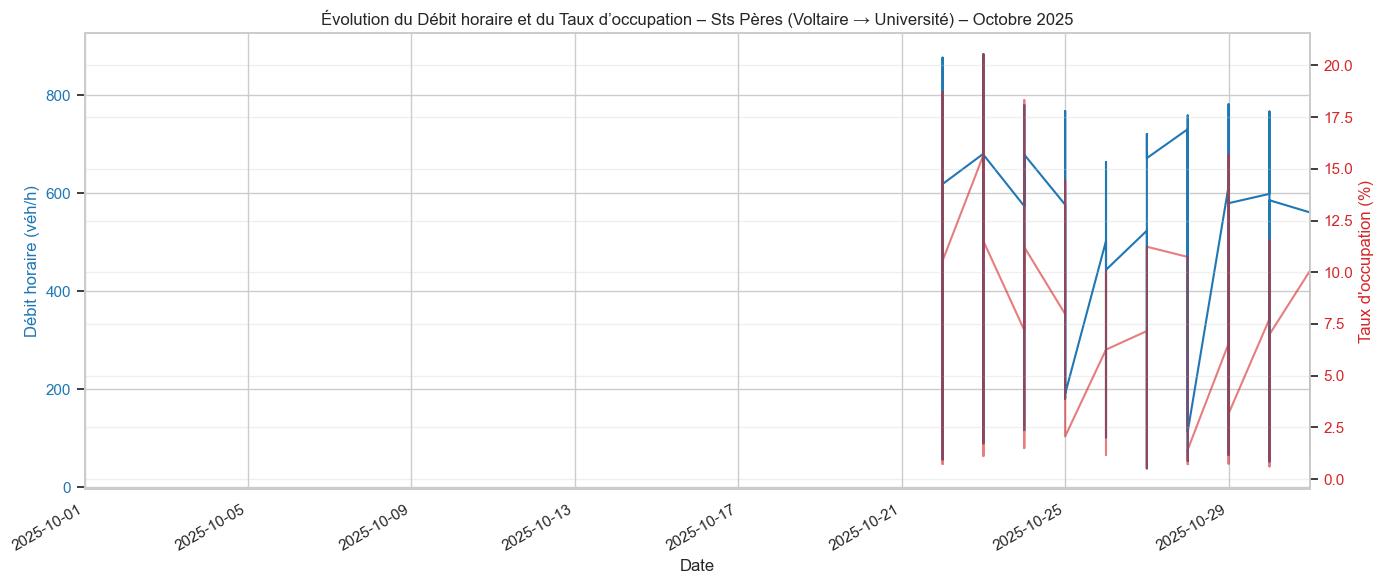

In [66]:
import matplotlib.pyplot as plt

# Tri du DataFrame pour éviter les courbes désordonnées
df_saint_peres = df_saint_peres.sort_values("date")

# Création du graphique
fig, ax1 = plt.subplots(figsize=(14,6))

# Débit horaire (axe gauche)
ax1.plot(df_saint_peres["date"], df_saint_peres["Débit horaire"], color='tab:blue', label="Débit horaire (véh/h)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Débit horaire (véh/h)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Taux d’occupation (axe droit)
ax2 = ax1.twinx()
ax2.plot(df_saint_peres["date"], df_saint_peres["Taux d'occupation"], color='tab:red', alpha=0.6, label="Taux d'occupation (%)")
ax2.set_ylabel("Taux d'occupation (%)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# ✅ Zoom sur octobre 2025 (adapter si besoin)
ax1.set_xlim(pd.Timestamp("2025-10-01"), pd.Timestamp("2025-10-31"))

# Mise en forme
plt.title("Évolution du Débit horaire et du Taux d’occupation – Sts Pères (Voltaire → Université) – Octobre 2025")
fig.autofmt_xdate()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [67]:
# Filtrer à partir du 21 octobre 2025
mask = df_saint_peres["date"] >= "2025-10-22"
df_oct = df_saint_peres.loc[mask, ["date", "Débit horaire", "Taux d'occupation"]]

# Vérifier les NaN
nan_summary = df_oct.isna().sum()
print("🔍 Nombre de NaN à partir du 21 octobre 2025 :")
print(nan_summary)

# Afficher les lignes concernées si tu veux les voir
print("\n🧾 Lignes contenant des NaN :")
display(df_oct[df_oct.isna().any(axis=1)])


🔍 Nombre de NaN à partir du 21 octobre 2025 :
date                 0
Débit horaire        0
Taux d'occupation    0
dtype: int64

🧾 Lignes contenant des NaN :


,date,Débit horaire,Taux d'occupation


In [68]:
# On trie par date
df_saint_peres = df_saint_peres.sort_values("date")

# On garde uniquement les lignes de 2025
df_2025 = df_saint_peres[df_saint_peres["date"].dt.year == 2025]

# On retire les lignes où les targets sont NaN
df_valid_2025 = df_2025.dropna(subset=["Débit horaire", "Taux d'occupation"])

# Première et dernière date valides
first_valid_date_2025 = df_valid_2025["date"].iloc[0]
last_valid_date_2025 = df_valid_2025["date"].iloc[-1]

print("📆 Première date valide en 2025 :", first_valid_date_2025)
print("📅 Dernière date valide en 2025 :", last_valid_date_2025)


📆 Première date valide en 2025 : 2025-10-22 00:00:00
📅 Dernière date valide en 2025 : 2025-10-31 00:00:00


# LSTM 2 Targets sur 24H

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.2089 - val_loss: 0.0950
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1526 - val_loss: 0.0615
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1137 - val_loss: 0.0423
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0856 - val_loss: 0.0358
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0706 - val_loss: 0.0378
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0657 - val_loss: 0.0416
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0619 - val_loss: 0.0424
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0590 - val_loss: 0.0401
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0583 - val_loss: 0.0368
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0532 - val_loss: 0.0342
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0521 - val_loss: 0.0325
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0519 - val_loss: 0.0315
E

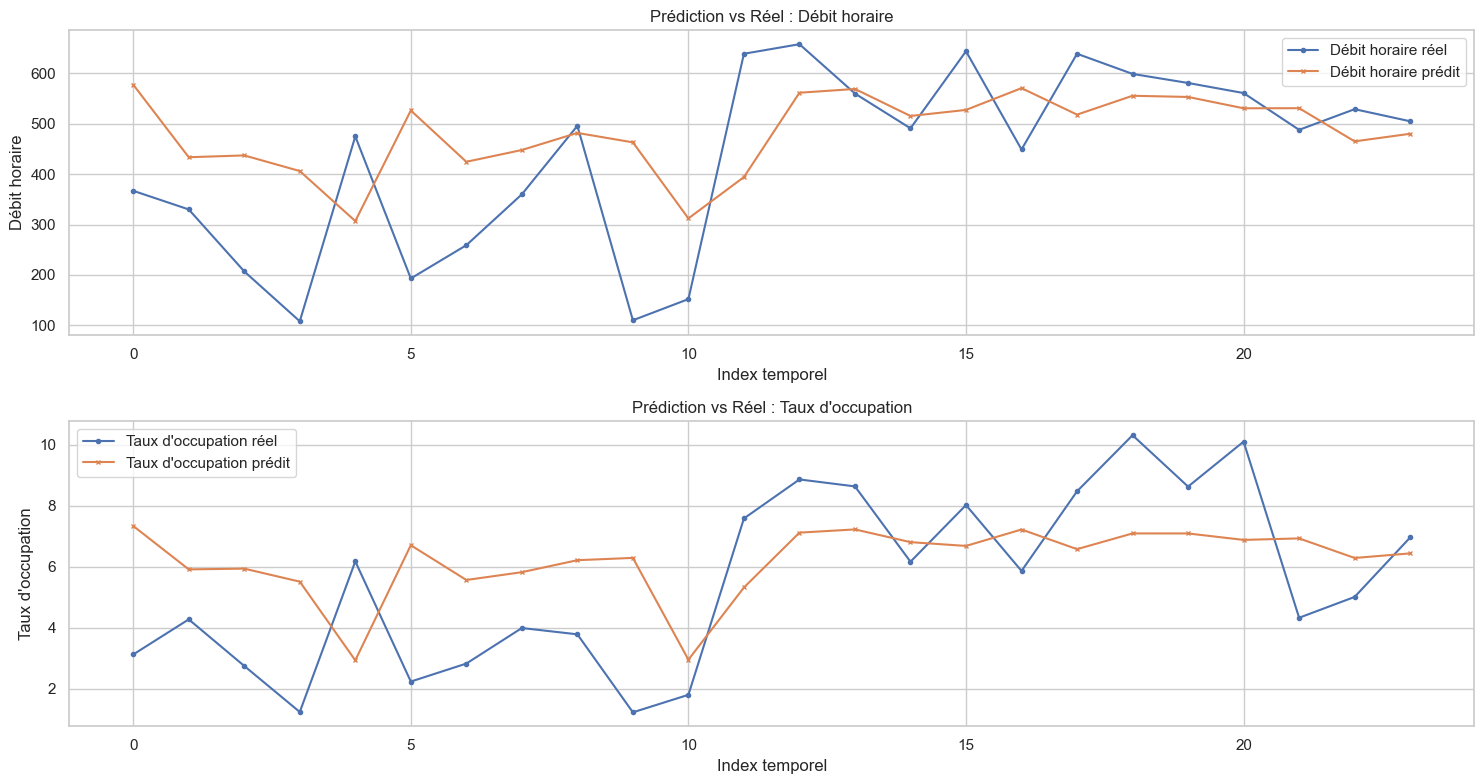

In [73]:
# Définition des targets et features
targets = ['Débit horaire', "Taux d'occupation"]
features = [
    'hour_sin', 'hour_cos', 
    'weekday_sin', 'weekday_cos', 
    'month_sin', 'month_cos', 
    'dayofyear_sin', 'dayofyear_cos',
    'is_weekend', 'is_holiday',
    'Vacances Scolaires Paris', 
    'temperature_2m (°C)', 'wind_speed_10m (km/h)',
    'precipitation (mm)', 'cloud_cover (%)',
    'Débit horaire_outlier_high', 'Débit horaire_outlier_low', 'Débit horaire_special_event',
    "Taux d'occupation_outlier_high", "Taux d'occupation_outlier_low", "Taux d'occupation_special_event"
]

# 1. Préparer les données
X_train, X_test, y_train, y_test, scaler_X, scaler_y = prepare_data(df_saint_peres, features, targets, seq_length=1)

# 2. Entraîner le modèle
model, history = train_lstm_24(X_train, y_train, X_test, y_test, lstm_units=64, dropout=0.2, epochs=20, batch_size=32)

# 3. Évaluer le modèle
y_test_inv, y_pred_inv = evaluate_model(model, X_test, y_test, scaler_y, targets)

# 4. Plot des prédictions
plot_predictions(y_test_inv, y_pred_inv, targets, n_plot=400) 

In [75]:
import pandas as pd

# S'assurer que la colonne date est en datetime
df_saint_peres['date'] = pd.to_datetime(df_saint_peres['date'])

# Dates à filtrer
dates_to_check = ['2024-11-11', '2025-07-14']

# Filtrer
filtered_dates = df_saint_peres[df_saint_peres['date'].dt.strftime('%Y-%m-%d').isin(dates_to_check)]

# Afficher les colonnes d'intérêt
display(filtered_dates[['date', 'hour', 'Débit horaire', "Taux d'occupation"]])


,date,hour,Débit horaire,Taux d'occupation



Débit horaire : 2 valeurs aberrantes


,date,hour,Débit horaire
2446,2025-02-02,11,2190.0
5981,2025-07-02,17,1587.0


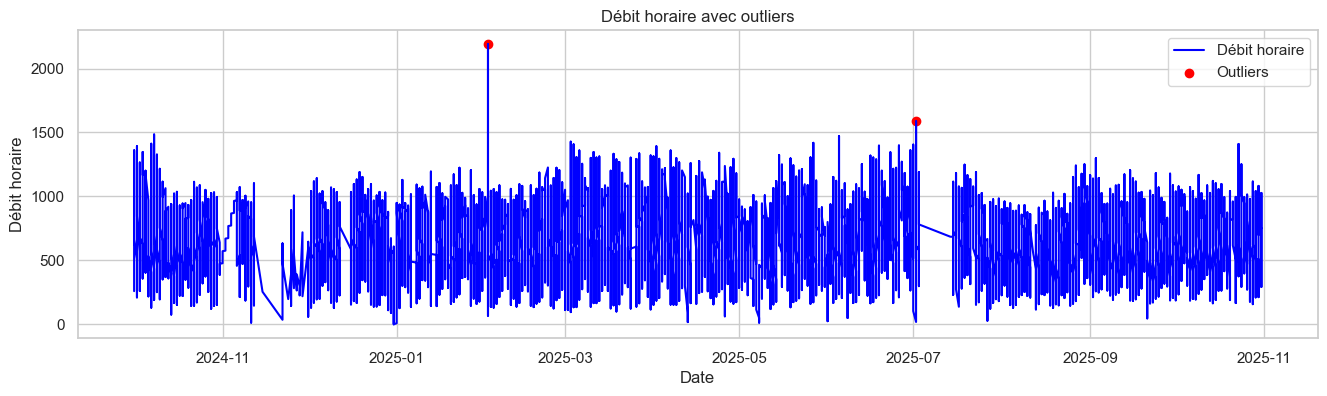


Taux d'occupation : 96 valeurs aberrantes


,date,hour,Taux d'occupation
1298,2024-12-11,15,66.403890
1317,2024-12-12,10,60.820560
1319,2024-12-12,12,55.766110
1320,2024-12-12,13,52.722230
1321,2024-12-12,14,52.535560
1322,2024-12-12,15,53.183890
1323,2024-12-12,16,50.250560
1324,2024-12-12,17,49.803359
1325,2024-12-12,18,49.356157
1326,2024-12-12,19,48.908956


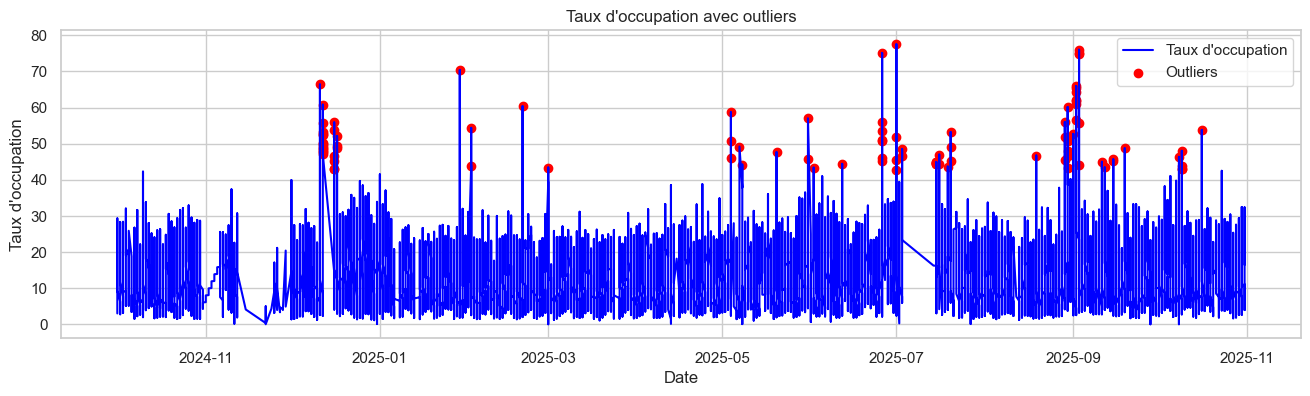

In [ ]:
import matplotlib.pyplot as plt

targets = ['Débit horaire', "Taux d'occupation"]

outliers_info = {}

for t in targets:
    Q1 = df_saint_peres[t].quantile(0.25)
    Q3 = df_saint_peres[t].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Filtrer les outliers
    outliers = df_saint_peres[(df_saint_peres[t] < lower) | (df_saint_peres[t] > upper)]
    
    # Récupérer date et heure
    outliers_info[t] = outliers[['date', 'hour', t]]
    print(f"\n{t} : {len(outliers)} valeurs aberrantes")
    display(outliers_info[t].head(10))  # affiche les 10 premiers

    # Plot
    plt.figure(figsize=(16,4))
    plt.plot(df_saint_peres['date'], df_saint_peres[t], label=t, color='blue')
    plt.scatter(outliers['date'], outliers[t], color='red', label='Outliers')
    plt.title(f"{t} avec outliers")
    plt.xlabel("Date")
    plt.ylabel(t)
    plt.legend()
    plt.show()




=== Analyse des outliers pour : Débit horaire ===
⚠️ Outliers détectés (hauts et bas) :
           date  hour  Débit horaire
2446 2025-02-02    11         2190.0
5981 2025-07-02    17         1587.0
1713 2024-12-31    22            0.0
1714 2024-12-31    23            0.0
1712 2024-12-31    21            1.0
1711 2024-12-31    20            2.0
1715 2025-01-01     0            8.0
990  2024-11-11    10           13.0
4669 2025-05-08    18           13.0
4668 2025-05-08    17           15.0
4093 2025-04-13     2           17.0
5964 2025-07-02     0           18.0
1708 2024-12-31    17           24.0
5236 2025-06-01    16           24.0
991  2024-11-11    11           26.0
4097 2025-04-13     6           26.0
4095 2025-04-13     4           27.0
6313 2025-07-27    13           28.0
5965 2025-07-02     1           29.0
5234 2025-06-01    14           32.0
4667 2025-05-08    16           33.0
4094 2025-04-13     3           34.0


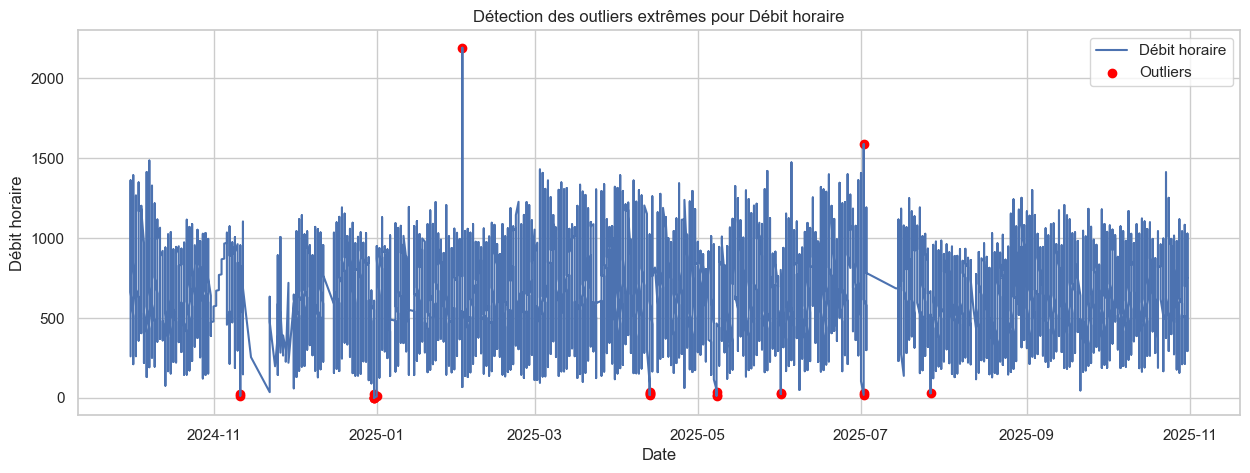


=== Analyse des outliers pour : Taux d'occupation ===
⚠️ Outliers détectés (hauts et bas) :
           date  hour  Taux d'occupation
1298 2024-12-11    15          66.403890
1317 2024-12-12    10          60.820560
1319 2024-12-12    12          55.766110
1320 2024-12-12    13          52.722230
1321 2024-12-12    14          52.535560
1322 2024-12-12    15          53.183890
1323 2024-12-12    16          50.250560
1324 2024-12-12    17          49.803359
1325 2024-12-12    18          49.356157
1326 2024-12-12    19          48.908956
1327 2024-12-12    20          48.461754
1328 2024-12-12    21          48.014553
1329 2024-12-12    22          47.567352
1330 2024-12-12    23          47.120150
1343 2024-12-16    12          55.886110
1344 2024-12-16    13          53.796670
1345 2024-12-16    14          46.523340
1346 2024-12-16    15          45.232780
1349 2024-12-16    18          42.994450
1350 2024-12-16    19          43.037220
1365 2024-12-17    10          49.406670
1367 

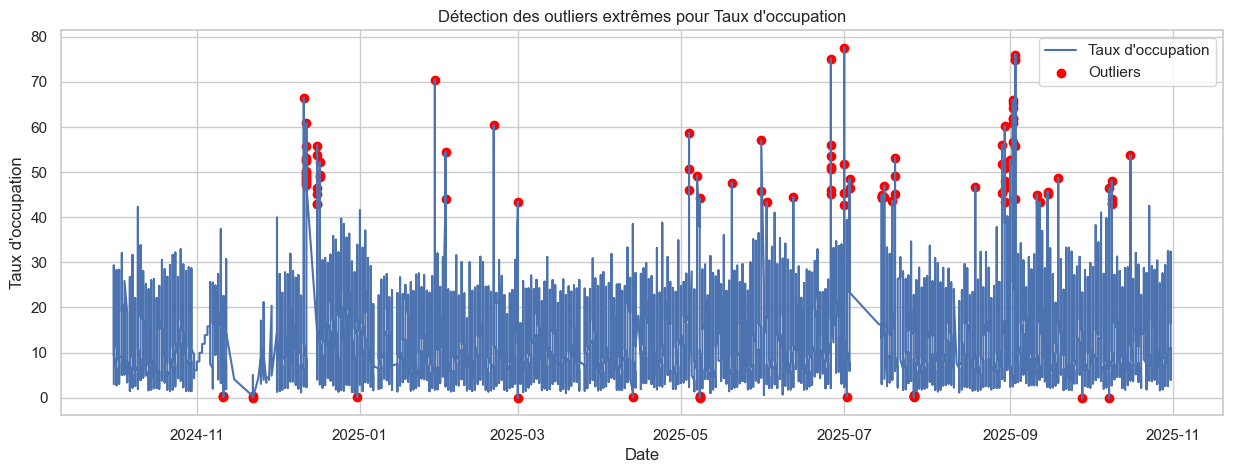

In [ ]:
import matplotlib.pyplot as plt

targets = ['Débit horaire', "Taux d'occupation"]

for target in targets:
    print(f"\n=== Analyse des outliers pour : {target} ===")
    
    # Détection des outliers hauts avec IQR
    q1 = df_saint_peres[target].quantile(0.25)
    q3 = df_saint_peres[target].quantile(0.75)
    iqr = q3 - q1

    upper_bound = q3 + 1.5 * iqr
    high_outliers = df_saint_peres[df_saint_peres[target] > upper_bound]

    # Détection des valeurs très basses : les 20 plus petites
    low_outliers = df_saint_peres.nsmallest(20, target)

    # Concaténation pour affichage
    all_outliers = pd.concat([high_outliers, low_outliers]).drop_duplicates()

    # Affichage des dates et heures des outliers
    print("⚠️ Outliers détectés (hauts et bas) :")
    print(all_outliers[['date', 'hour', target]])

    # Plot
    plt.figure(figsize=(15,5))
    plt.plot(df_saint_peres['date'], df_saint_peres[target], label=target)
    plt.scatter(all_outliers['date'], all_outliers[target], color='red', label='Outliers')
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.title(f'Détection des outliers extrêmes pour {target}')
    plt.legend()
    plt.show()


# LSTM 72h


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0976 - val_loss: 0.0790
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0819 - val_loss: 0.0655
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0658 - val_loss: 0.0502
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0512 - val_loss: 0.0399
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0400 - val_loss: 0.0337
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0324 - val_loss: 0.0291
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0283 - val_loss: 0.0273
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0270 - val_loss: 0.0266
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0262 - val_loss: 0.0265
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0259 - val_loss: 0.0263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
✅ Débit horaire : RMSE = 229.16, Moyenne = 447.18, Erreur relative = 51.25%
✅ Taux d'occupation : RMSE = 3.57, Moyenne = 5.57, Er

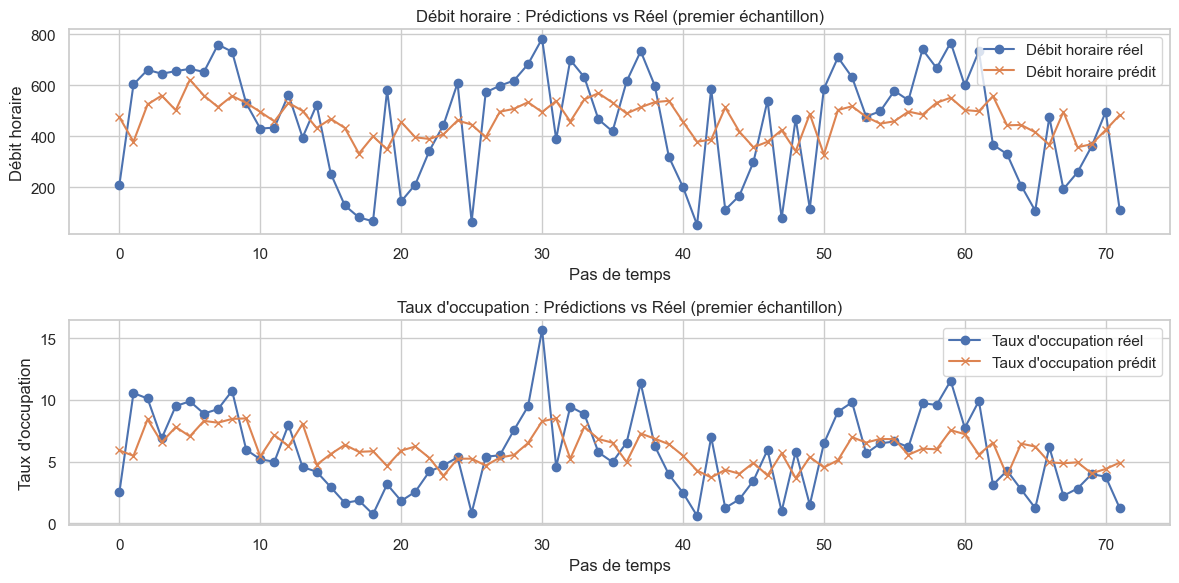

In [77]:
# 🔹 Appel du training
model, history, scaler_X, scalers_y, X_test, y_test = train_lstm_seq2seq(
    df=df_saint_peres,
    features=features,
    targets=targets,
    seq_length=24,
    pred_length=72,
    epochs=10,
    batch_size=32,
    log_transform=False
)
# 2️⃣ Évaluation et plot des prédictions
y_test_inv, y_pred_inv = evaluate_lstm_seq2seq(model, X_test, y_test, scalers_y, targets, n_plot=72)
